In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [18]:
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run-normality")

In [3]:
feature_paths = list(dataset.glob('hist_*')) + list(dataset.glob('reb_hist_*'))
feature_names = [ fp.stem for fp in feature_paths]
feature_names

['hist_R1_P8_d',
 'hist_R1_P8_u',
 'hist_R2_P12_d',
 'hist_R2_P12_u',
 'hist_R3_P24_u',
 'hist_R5_P36_u',
 'reb_hist_R1_P8_d',
 'reb_hist_R2_P12_d']

In [4]:
features = [np.load(fp) for fp in feature_paths]

In [5]:
labels = np.load(dataset / 'labels.npy')
y_set, y_tex = labels.T
unique_sets = np.unique(y_set)
unique_texs = np.unique(y_tex)
unique_sets, unique_texs

(array([1, 2, 3]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]))

In [7]:
def mean_within_classes(feature, classes, unique_classes):
    X_cl = np.array([ feature[classes == k] for k in unique_classes ])
    assert X_cl.shape[0] == len(unique_classes)
    assert X_cl.shape[2] == feature.shape[1]
    return X_cl.mean(axis=1)


In [8]:
def check_normality(feature, classes, unique_classes, alpha=0.05):
    X_cl = np.array([ feature[classes == k] for k in unique_classes ])
    means = X_cl.mean(axis=1)
    deltas = np.array([ X_cl[k] - means[k] for k in range(unique_classes.shape[0]) ])

    n_notnormal = []
    for k in range(unique_classes.shape[0]):
        s, pvals = sp.stats.shapiro(deltas[k], axis=0)
        n_notnormal.append((pvals < alpha).sum())
    
    median_notnormality = np.median(n_notnormal) / feature.shape[1]
    # print(f"On median across all classes, {median_notnormality*100:.2f}% of features are likely NOT normal")
    return median_notnormality

In [59]:
normality_stats = []

print("Using Shapiro-Wilks test of normality for each descriptor")
for f,fn in zip(features, feature_names):
    print(f"Feature '{fn:18}': ", end='')
    median_notnormality = check_normality(f, y_tex, unique_texs)
    normality_stats.append(median_notnormality)
    print(f"{median_notnormality*100:5.2f}% features likely not normal")

Using Shapiro-Wilks test of normality for each descriptor
Feature 'hist_R1_P8_d      ': 82.03% features likely not normal
Feature 'hist_R1_P8_u      ': 90.00% features likely not normal
Feature 'hist_R2_P12_d     ': 

y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:657: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


98.22% features likely not normal
Feature 'hist_R2_P12_u     ': 71.43% features likely not normal
Feature 'hist_R3_P24_u     ': 80.77% features likely not normal
Feature 'hist_R5_P36_u     ': 86.84% features likely not normal
Feature 'reb_hist_R1_P8_d  ': 54.69% features likely not normal
Feature 'reb_hist_R2_P12_d ': 65.56% features likely not normal


In [50]:
from matplotlib.colors import TABLEAU_COLORS
TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

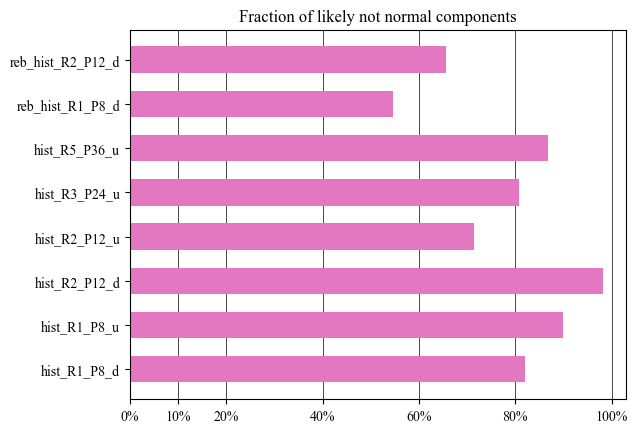

In [65]:
plt.barh(feature_names, normality_stats, height=0.6, color='tab:pink')
plt.gca().set_axisbelow(True)
plt.grid(axis='x', color='k', linewidth=0.5)
plt.title('Fraction of likely not normal components')
ticks = list(np.linspace(0,1,6))
plt.xticks(ticks + [ 0.1 ], [ f"{t*100:.0f}%" for t in ticks] + [ "10%" ]);
plt.xlim(0,1.03)
plt.savefig('normality.png', dpi=150, bbox_inches='tight')

In [32]:
print("Using Shapiro-Wilks test of normality for each descriptor CONSIDERING SUBSETS")

subsets = [[f[y_set==ks] for f in features] for ks in unique_sets]
subset_ys = [y_tex[y_set==ks] for ks in unique_sets]

for s,y in zip(subsets,subset_ys):
    print([ss.shape for ss in s])
    print(y.shape)

Using Shapiro-Wilks test of normality for each descriptor CONSIDERING SUBSETS
[(325, 256), (325, 10), (325, 4096), (325, 14), (325, 26), (325, 38), (325, 64), (325, 90)]
(325,)
[(325, 256), (325, 10), (325, 4096), (325, 14), (325, 26), (325, 38), (325, 64), (325, 90)]
(325,)
[(1300, 256), (1300, 10), (1300, 4096), (1300, 14), (1300, 26), (1300, 38), (1300, 64), (1300, 90)]
(1300,)


In [56]:
print("Using Shapiro-Wilks test of normality for each descriptor CONSIDERING SUBSETS")

subset_normality_stats = []

for subset_features, y, s in zip(subsets, subset_ys, unique_sets):
    print("SUBSET ", s)
    normality_stats = []
    for f, fn in zip(subset_features, feature_names):
        print(f"Feature '{fn:18}' in set {s}: ", end='')
        median_notnormality = check_normality(f, y, unique_texs)
        normality_stats.append(median_notnormality)
        print(f"{median_notnormality*100:5.2f}% features likely not normal")
    print()
    subset_normality_stats.append(normality_stats)

Using Shapiro-Wilks test of normality for each descriptor CONSIDERING SUBSETS
SUBSET  1
Feature 'hist_R1_P8_d      ' in set 1: 37.50% features likely not normal
Feature 'hist_R1_P8_u      ' in set 1: 10.00% features likely not normal
Feature 'hist_R2_P12_d     ' in set 1: 

y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:657: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


67.46% features likely not normal
Feature 'hist_R2_P12_u     ' in set 1:  7.14% features likely not normal
Feature 'hist_R3_P24_u     ' in set 1:  7.69% features likely not normal
Feature 'hist_R5_P36_u     ' in set 1: 23.68% features likely not normal
Feature 'reb_hist_R1_P8_d  ' in set 1: 12.50% features likely not normal
Feature 'reb_hist_R2_P12_d ' in set 1: 11.11% features likely not normal

SUBSET  2
Feature 'hist_R1_P8_d      ' in set 2: 37.50% features likely not normal
Feature 'hist_R1_P8_u      ' in set 2: 10.00% features likely not normal
Feature 'hist_R2_P12_d     ' in set 2: 67.72% features likely not normal
Feature 'hist_R2_P12_u     ' in set 2:  7.14% features likely not normal
Feature 'hist_R3_P24_u     ' in set 2:  7.69% features likely not normal
Feature 'hist_R5_P36_u     ' in set 2: 23.68% features likely not normal
Feature 'reb_hist_R1_P8_d  ' in set 2: 12.50% features likely not normal
Feature 'reb_hist_R2_P12_d ' in set 2: 12.22% features likely not normal

SUBSE

In [64]:
for n, stats in enumerate(subset_normality_stats):
    fig = plt.figure()
    plt.gca().set_axisbelow(True)
    plt.grid(axis='x', color='k', linewidth=0.5)
    plt.barh(feature_names, stats, height=0.6, color='tab:pink')
    plt.title(f'Fraction of likely not normal components [Subset {n+1}]')
    ticks = list(np.linspace(0,1,6))
    plt.xticks(ticks + [ 0.1 ], [ f"{t*100:.0f}%" for t in ticks] + [ "10%" ]);
    plt.xlim(0,1.03)
    plt.savefig(f'normality-subset{n+1}.png', dpi=150, bbox_inches='tight')
    plt.close(fig)